# Machine Learning

In [1]:
from pyspark.sql import SparkSession
from pyspark.mllib.util import MLUtils
from pyspark.ml.classification import LogisticRegression
import matplotlib.pyplot as plt

In [2]:
spark = SparkSession.builder \
    .master("local[16]") \
    .appName("machine_learning") \
    .getOrCreate()

22/12/15 20:48:10 WARN Utils: Your hostname, Zephyrus resolves to a loopback address: 127.0.1.1; using 172.19.222.122 instead (on interface eth0)
22/12/15 20:48:10 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/12/15 20:48:12 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## Loading the Data

In [3]:
data_A = spark.read.format("libsvm").option("numFeatures", 5674).load("data/data_A")
data_B = spark.read.format("libsvm").option("numFeatures", 26854).load("data/data_B")

In [4]:
A_train, A_test = data_A.randomSplit([0.6,0.4], seed=11)
B_train, B_test = data_B.randomSplit([0.6,0.4], seed=11)

## Training the Model

In [93]:
lr_a = LogisticRegression(maxIter=10, regParam=0.1)
lr_b = LogisticRegression(maxIter=10, regParam=0.2)

# Fit the models
model_a = lr_a.fit(A_train)
model_b = lr_b.fit(B_train)

In [94]:
# Print the coefficients and intercept for logistic regression
print(f"Model A Intercept: {model_a.intercept:.4f}")
print(f"Model B Intercept: {model_b.intercept:.4f}")

Model A Intercept: 1.8444
Model B Intercept: 1.9441


## Determine Ideal Threshold

In [95]:
def best_threshold(summary):
    # Set the model threshold to maximize F-Measure
    fMeasure = summary.fMeasureByThreshold
    maxFMeasure = fMeasure.groupBy().max('F-Measure').select('max(F-Measure)').head()
    bestThreshold = fMeasure.where(fMeasure['F-Measure'] == maxFMeasure['max(F-Measure)']) \
        .select('threshold').head()['threshold']
    return bestThreshold

In [103]:
# Extract the summary from the returned LogisticRegressionModel instance trained
summary_A = model_a.summary
summary_B = model_b.summary

best_threshold_A = best_threshold(summary_A)
best_threshold_B = best_threshold(summary_B)

print(f"Threshold A: {best_threshold_A:.3f}")
print(f"Threshold B: {best_threshold_B:.3f}")

model_a.setThreshold(best_threshold_A)
model_b.setThreshold(best_threshold_B)

Threshold A: 0.708
Threshold B: 0.756


LogisticRegressionModel: uid=LogisticRegression_b7c27a8a3ee4, numClasses=2, numFeatures=26854

## Measure Precision/Recall of Models

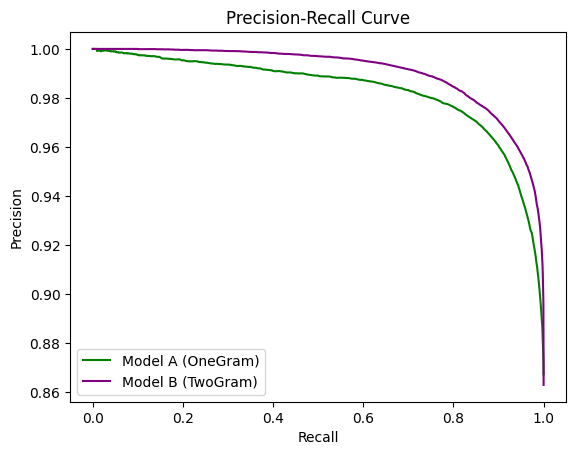

In [124]:
pr_a = model_a.summary.pr.toPandas()
pr_b = model_b.summary.pr.toPandas()

# #create precision recall curve
fig, ax = plt.subplots()
ax.plot(pr_a.recall, pr_a.precision, color='green', label="Model A (OneGram)")
ax.plot(pr_b.recall, pr_b.precision, color='purple', label="Model B (TwoGram)")

#add axis labels to plot
ax.set_title('Precision-Recall Curve')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')
ax.legend()

plt.savefig("imgs/precision_recall_curve")
plt.show()

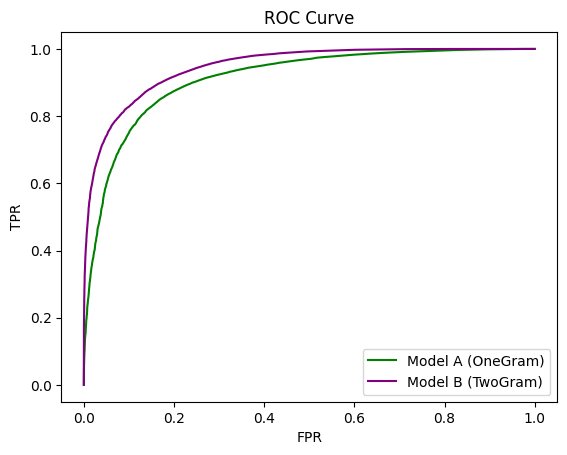

In [126]:
roc_a = model_a.summary.roc.toPandas()
roc_b = model_b.summary.roc.toPandas()

# #create precision recall curve
fig, ax = plt.subplots()
ax.plot(roc_a.FPR, roc_a.TPR, color='green', label="Model A (OneGram)")
ax.plot(roc_b.FPR, roc_b.TPR, color='purple', label="Model B (TwoGram)")

#add axis labels to plot
ax.set_title('ROC Curve')
ax.set_ylabel('TPR')
ax.set_xlabel('FPR')
ax.legend()

plt.savefig("imgs/ROC_curve")

plt.show()

In [109]:
print(f"OneGram areaUnderROC: {model_a.summary.areaUnderROC:.3f}")
print(f"TwoGram areaUnderROC: {model_b.summary.areaUnderROC:.3f}")

OneGram areaUnderROC: 0.912
TwoGram areaUnderROC: 0.948


In [106]:
A_train_predictions = model_a.transform(A_train)
A_train_accuracy = A_train_predictions.filter(A_train_predictions.label == A_train_predictions.prediction).count() / float(A_train_predictions.count())
print(f"Model A Train Acc: {A_train_accuracy:.3f}")

A_test_predictions = model_a.transform(A_test)
A_test_accuracy = A_test_predictions.filter(A_test_predictions.label == A_test_predictions.prediction).count() / float(A_test_predictions.count())
print(f"Model A Test Acc: {A_test_accuracy:.3f}")

Model A Train Acc: 0.909
Model A Test Acc: 0.897


In [107]:
B_train_predictions = model_b.transform(B_train)
B_train_accuracy = B_train_predictions.filter(B_train_predictions.label == B_train_predictions.prediction).count() / float(B_train_predictions.count())
print(f"Model A Train Acc: {B_train_accuracy:.3f}")

B_test_predictions = model_b.transform(B_test)
B_test_accuracy = B_test_predictions.filter(B_test_predictions.label == B_test_predictions.prediction).count() / float(B_test_predictions.count())
print(f"Model A Test Acc: {B_test_accuracy:.3f}")

Model A Train Acc: 0.931
Model A Test Acc: 0.888
